### Initial Implementation

##### 1. Imports

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, accuracy_score

##### 2. Load Dataset

In [ ]:
data = load_dataset("shainar/BEAD", "Full_Annotations", split="full")
print(data)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

Full.csv:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
    num_rows: 3674927
})


In [ ]:
df = data.to_pandas()
print(df.head())

                                                text             dimension  \
0  Where will this leave the kids??? That my frie...  Ageism and sentiment   
1   I had a feeling of impending doom &amp; then ...  Ageism and sentiment   
2                                 I no feel good ..   Ageism and sentiment   
3  Back in Hotlanta for a about a week, then off ...  Ageism and sentiment   
4  Kids toys &amp; stamping stuff cleaned up... N...  Ageism and sentiment   

            biased_words          aspect            label sentiment  toxic  \
0                     []     Transphobia  Slightly Biased  Negative    0.0   
1  ['impending', 'doom']  Climate change    Highly Biased  Negative    1.0   
2                     []    Body-shaming          Neutral  Positive    0.0   
3                     []       Lifestyle  Slightly Biased  Negative    0.0   
4                     []           Hobby          Neutral   Neutral    1.0   

  identity_mention  
0               NO  
1               NO  

##### 3. Text Pre-processing

In [ ]:
print(df.isnull().sum())

text                     2
dimension                0
biased_words             0
aspect              177970
label                    0
sentiment                0
toxic                    0
identity_mention         0
dtype: int64


In [ ]:
df = df.dropna(subset=['text'])

In [ ]:
df = df.drop_duplicates(subset='text')

In [ ]:
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 1
Max text snippet length: 37903
Avg text snippet length: 211.07703640651337


In [ ]:
text_len = df['text'].str.len()
ind = text_len.idxmin()
row = df.loc[ind]
print(row)

text                           .
dimension               toxicity
biased_words                  []
aspect              Perspective 
label                    Neutral
sentiment                Neutral
toxic                        1.0
identity_mention              NO
Name: 746630, dtype: object


In [ ]:
min_len = 5
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 825 rows.


In [ ]:
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 5
Max text snippet length: 37903
Avg text snippet length: 211.12367156175208


In [ ]:
import re

text = df['text']

text = text.apply(lambda x: x.lower())
def edit(text):
	text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)
	text = re.sub(r'https?://\S+|www\.\S+', '', text)
	text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text
text = text.apply(edit)

df['text'] = text

In [ ]:
min_len = 5
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 2637 rows.


In [ ]:
df['text'] = df['text'].astype(str)
df['text'] = df['text'].fillna('')

##### 4. Dataset Characteristics

In [ ]:
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 5
Max text snippet length: 32191
Avg text snippet length: 203.62309087739558


In [ ]:
print(f"{len(df)} rows.")

3671320 rows.


In [ ]:
print(df['label'].value_counts())

label
Neutral            1882864
Slightly Biased    1041122
Highly Biased       747334
Name: count, dtype: int64


In [ ]:
print(df['sentiment'].value_counts())

sentiment
Positive    1678404
Negative    1224348
Neutral      768568
Name: count, dtype: int64


In [ ]:
print(df['toxic'].value_counts())

toxic
0.0    2444805
1.0    1226515
Name: count, dtype: int64


##### 5. One-Hot Encoding

In [ ]:
y = pd.DataFrame(data)
target_columns = ['label', 'sentiment', 'toxic']

encoders = {}
for col in target_columns:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  encoders[col] = le

print(df.head())

                                                text             dimension  \
0  where will this leave the kids??? that my frie...  Ageism and sentiment   
1  i had a feeling of impending doom then hear ab...  Ageism and sentiment   
2                                  i no feel good ..  Ageism and sentiment   
3  back in hotlanta for a about a week, then off ...  Ageism and sentiment   
4  kids toys stamping stuff cleaned up... next ki...  Ageism and sentiment   

            biased_words          aspect  label  sentiment  toxic  \
0                     []     Transphobia      2          0      0   
1  ['impending', 'doom']  Climate change      0          0      1   
2                     []    Body-shaming      1          2      0   
3                     []       Lifestyle      2          0      0   
4                     []           Hobby      1          1      1   

  identity_mention  
0               NO  
1               NO  
2               NO  
3               NO  
4          

In [ ]:
print(encoders['toxic'].classes_)

[0. 1.]


##### 6. Tokenisation & Padding

In [ ]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
y = df[['label', 'sentiment', 'toxic']]
print(y)

         label  sentiment  toxic
0            2          0      0
1            0          0      1
2            1          2      0
3            2          0      0
4            1          1      1
...        ...        ...    ...
3674922      2          0      0
3674923      2          1      1
3674924      2          2      1
3674925      2          2      0
3674926      2          2      0

[3671320 rows x 3 columns]


##### 7. Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

##### 8. Model Architecture

In [ ]:
print("X_train:", X_train.shape)
print("y_train[label]:", y_train["label"].shape)
print("y_train[sentiment]:", y_train["sentiment"].shape)
print("y_train[toxic]:", y_train["toxic"].shape)

print("X_valid:", X_valid.shape)
print("y_valid[label]:", y_valid["label"].shape)
print("y_valid[sentiment]:", y_valid["sentiment"].shape)
print("y_valid[toxic]:", y_valid["toxic"].shape)

y_train_label = y_train["label"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_valid_label = y_valid["label"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (2937056, 100)
y_train[label]: (2937056,)
y_train[sentiment]: (2937056,)
y_train[toxic]: (2937056,)
X_valid: (367132, 100)
y_valid[label]: (367132,)
y_valid[sentiment]: (367132,)
y_valid[toxic]: (367132,)


In [ ]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# output layers
output_label = Dense(len(encoders['label'].classes_), activation='softmax', name="output_l")(x)
output_sentiment = Dense(len(encoders['sentiment'].classes_), activation='softmax', name="output_s")(x)
output_toxic = Dense(len(encoders['toxic'].classes_), activation='softmax', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_label, output_sentiment, output_toxic])

# model.build(input_shape=(None, MAX_LEN))
model.compile(
    optimizer='adam',
    loss={
        "output_l": "sparse_categorical_crossentropy",
        "output_s": "sparse_categorical_crossentropy",
        "output_t": "sparse_categorical_crossentropy"
    },
    metrics={
        "output_l": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
  )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_l (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,848 (5.29 MB)

 Trainable params: 1,387,720 (5.29 MB)

 Non-trainable params: 128 (512.00 B)

##### 9. Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train,
    {
        "output_l": y_train_label,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_l": y_valid_label,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
91783/91783 ━━━━━━━━━━━━━━━━━━━━ 1468s 16ms/step - loss: 1.3716 - output_l_accuracy: 0.7962 - output_l_loss: 0.5129 - output_s_accuracy: 0.8572 - output_s_loss: 0.4152 - output_t_accuracy: 0.7992 - output_t_loss: 0.4436 - val_loss: 1.0207 - val_output_l_accuracy: 0.8569 - val_output_l_loss: 0.3723 - val_output_s_accuracy: 0.9085 - val_output_s_loss: 0.2887 - val_output_t_accuracy: 0.8420 - val_output_t_loss: 0.3596
Epoch 2/10
91783/91783 ━━━━━━━━━━━━━━━━━━━━ 1512s 16ms/step - loss: 1.0987 - output_l_accuracy: 0.8500 - output_l_loss: 0.4026 - output_s_accuracy: 0.9052 - output_s_loss: 0.3158 - output_t_accuracy: 0.8361 - output_t_loss: 0.3804 - val_loss: 0.9962 - val_output_l_accuracy: 0.8605 - val_output_l_loss: 0.3631 - val_output_s_accuracy: 0.9112 - val_output_s_loss: 0.2804 - val_output_t_accuracy: 0.8452 - val_output_t_loss: 0.3527
Epoch 3/10
91783/91783 ━━━━━━━━━━━━━━━━━━━━ 1457s 16ms/step - loss: 1.0675 - output_l_accuracy: 0.8549 - output_l_loss: 0.3890 - output_s_ac

##### 10. Model Evaluation

In [ ]:
y_pred_probs = model.predict(X_test)

y_pred_label = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

y_true_label = y_test["label"].to_numpy()
y_true_sentiment = y_test["sentiment"].to_numpy()
y_true_toxic = y_test["toxic"]

print("=== Label Task ===")
print("Accuracy:", accuracy_score(y_true_label, y_pred_label))
print(classification_report(y_true_label, y_pred_label, target_names=encoders["label"].classes_))

print("\n=== Sentiment Task ===")
print("Accuracy:", accuracy_score(y_true_sentiment, y_pred_sentiment))
print(classification_report(y_true_sentiment, y_pred_sentiment, target_names=encoders["sentiment"].classes_))

print("\n=== Toxic Task ===")
print("Accuracy:", accuracy_score(y_true_toxic, y_pred_toxic))
# print(classification_report(y_true_toxic, y_pred_toxic, target_names=encoders["toxic"].classes_))
print("Toxic Classification Report:\n",
      classification_report(
          y_true_toxic,
          y_pred_toxic,
          target_names=[str(cls) for cls in encoders["toxic"].classes_]   # ensure strings
      ))

11473/11473 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step
=== Label Task ===
Accuracy: 0.861186167373043
                 precision    recall  f1-score   support

  Highly Biased       0.85      0.80      0.82     74734
        Neutral       0.91      0.94      0.93    188287
Slightly Biased       0.78      0.76      0.77    104111

       accuracy                           0.86    367132
      macro avg       0.84      0.83      0.84    367132
   weighted avg       0.86      0.86      0.86    367132


=== Sentiment Task ===
Accuracy: 0.9125355457982415
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90    122435
     Neutral       0.94      0.87      0.90     76857
    Positive       0.91      0.94      0.93    167840

    accuracy                           0.91    367132
   macro avg       0.92      0.90      0.91    367132
weighted avg       0.91      0.91      0.91    367132


=== Toxic Task ===
Accuracy: 0.8461398080254513
Toxic Classification R

##### 11. Visualization

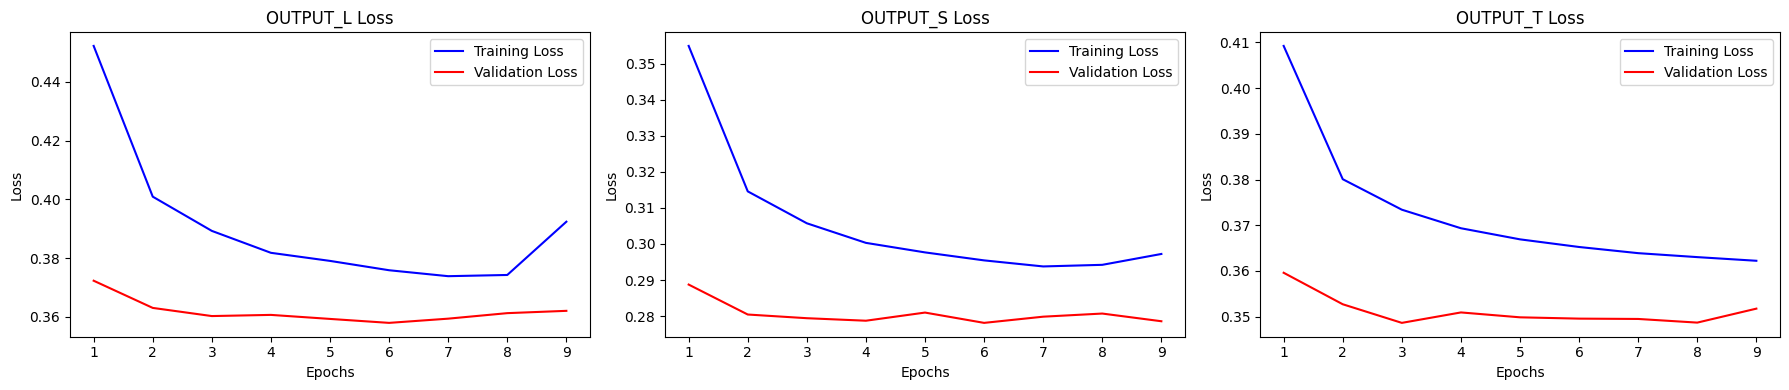

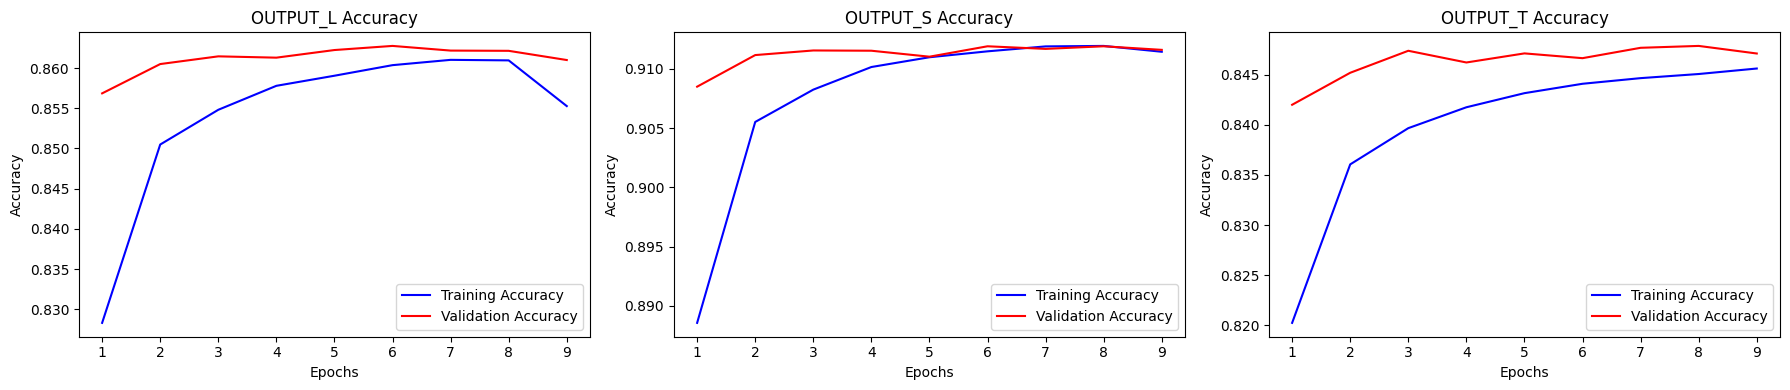

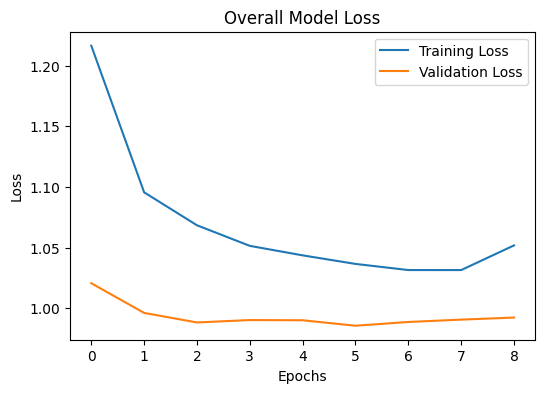

In [ ]:
import matplotlib.pyplot as plt

def plot_output(history, outputs, metric="accuracy"):
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

    # Accuracy plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_loss = history.history[f"{output}_loss"]
        val_loss = history.history[f"val_{output}_loss"]

        axes[i].plot(epochs, train_loss, "b", label="Training Loss")
        axes[i].plot(epochs, val_loss, "r", label="Validation Loss")
        axes[i].set_title(f"{output.upper()} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # Loss plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_metric = history.history[f"{output}_{metric}"]
        val_metric = history.history[f"val_{output}_{metric}"]

        axes[i].plot(epochs, train_metric, "b", label=f"Training {metric.title()}")
        axes[i].plot(epochs, val_metric, "r", label=f"Validation {metric.title()}")
        axes[i].set_title(f"{output.upper()} {metric.title()}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Overall Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

outputs = ["output_l", "output_s", "output_t"]
plot_output(history, outputs, metric="accuracy")
